In [16]:
from cbf_opt import dynamics, cbf
from cbf_hjr import cbf as cbf_hjr, dynamics as dynamics_hjr
import hj_reachability as hj
import jax.numpy as jnp

In [17]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.animation as anim

State: $\mathbf{x} = [y, v_y, \phi, \omega]^T$

Dynamics: 
$$\dot{x} = \begin{bmatrix}x_2 \\ \frac{ - C_D^v x_2}{m} - g \\ x_4 \\ \frac{- C_D^\phi x_4}{I{yy}}\end{bmatrix} + \begin{bmatrix}0 & 0 \\ \frac{\cos(x_3)}{m} & \frac{\cos(x_3)}{m} \\ 0 & 0 \\ -\frac{l}{I_{yy}} & \frac{l}{I_{yy}}\end{bmatrix}\underbrace{\begin{bmatrix}T_1 \\ T_2\end{bmatrix}}_{u}

In [18]:
class QuadVerticalDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 4
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([
            state[1], 
            -state[1] * self.Cd_v / self.mass - self.g, 
            state[3], 
            -state[3] * self.Cd_phi / self.mass
            ])
    
    def control_matrix(self, state, time=0.0):
        return jnp.array([
            [0, 0], 
            [jnp.cos(state[2]), jnp.cos(state[2])], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

In [19]:
params = dict()
params["Cd_v"] = 0.25
params["g"] = 9.81
params["Cd_phi"] = 0.02255
params["mass"] = 2.5
params["length"] = 1.0
params["Iyy"] = 1.0
params["dt"] = 0.01

dyn = QuadVerticalDynamics(params)

In [20]:
umax = 0.75 * params["mass"] * params["g"] * jnp.ones(2)
umin = jnp.zeros_like(umax)

## Safe set: 
$$\mathcal{E} = [1, 9] \times [-6, 6] \times [-\infty, \infty] \times [-8,8]$$

In [21]:
def safe_set(state):
    """A real-valud function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    return jnp.min(jnp.array([state[0] - 1, 9 - state[0], state[1] + 6, 6 - state[1], state[3] + 8, 8 - state[3]]))


Two options: We learn a value function that indicates backup set (in a small region of the state space maybe around the hovering) and an unsafe region (outside of the operating range) OR we define a CBF ourselves with a bit of imagination

## Current implementation: Self-defined approximately correct value function

In [22]:
class QuadVerticalCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.scaling = params["scaling"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return 10 - self.scaling[0] * (5 - state[0]) ** 2 - self.scaling[1] * (state[1]) ** 2 - self.scaling[2] * (state[2]) ** 2 - self.scaling[3] * (state[3]) ** 2

    def vf_dt_partial(self, state, time=0.0):
        return 0.0
    
    def _grad_vf(self, state, time=0.0):
        return self.scaling * np.array([2 * (5 - state[0]), - 2 * state[1], - 2 * state[2], - 2 * state[3]])

In [23]:
cbf_params = dict()
cbf_params["scaling"] = jnp.array([0.75, 0.5, 2., 0.5])
quad_cbf = QuadVerticalCBF(dyn, cbf_params)

## Classical HJ solution

In [24]:
dyn_hjr = dynamics_hjr.HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([0., -8., -jnp.pi, -10.]), hi=jnp.array([10., 8., jnp.pi, 10.]))
grid_resolution = (25, 25, 30, 25)  # can/should be increased if running on GPU, or if extra patient

In [25]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [26]:
safe_values = hj.utils.multivmap(safe_set, jnp.arange(4))(grid.states)

In [27]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(safe_values))

In [28]:
init_values = safe_values
initial_time = 0.
final_time = -5.
times = jnp.linspace(initial_time, final_time, 101)
target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)

100%|##########|  5.0000/5.0 [06:00<00:00, 72.07s/sim_s]


In [29]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
        
    cont = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], value_function[i][:,12,:,12], levels=[0], colors='g')

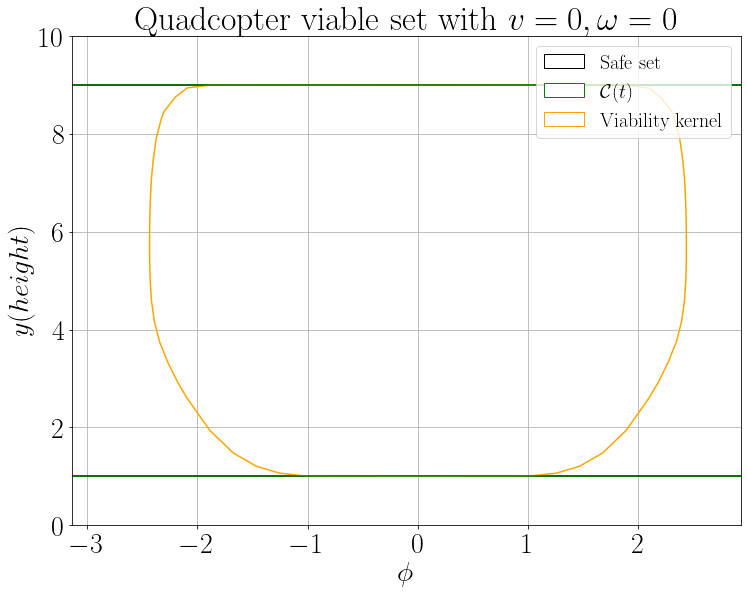

In [30]:
value_function = target_values_hjr
filename="quad_cbf.mp4"
proxy = [] 

fig, ax = plt.subplots(figsize=(12, 9))

cs = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], safe_values[:,12,:,12], levels=[0], colors='k')
proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') for pc in cs.collections]

cont = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], value_function[0][:,12,:,12], levels=[0], colors='g')
proxy += [plt.Rectangle((0,0),1,1,ec = 'g', fc='white')
        for pc in cont.collections]
cs = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], value_function[-1][:,12,:,12], levels=[0], colors='orange')
proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$\\phi$")
ax.set_ylabel("$y (height)$")
ax.set_title("Quadcopter viable set with $v=0, \omega = 0$")
ax.legend(proxy, ["Safe set", "$\mathcal{C}(t)$", "Viability kernel"], prop={'size': 20})

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0], interval=50)
# animation.save(filename, writer='ffmpeg', fps=30)

# CBF HJR

In [31]:
quad_tabular_cbf = cbf_hjr.TabularCBF(dyn, grid=grid)

In [32]:
quad_tabular_cbf.tabularize_cbf(quad_cbf)

100%|██████████| 25/25 [1:00:20<00:00, 144.81s/it]


NameError: name 'target_values' is not defined

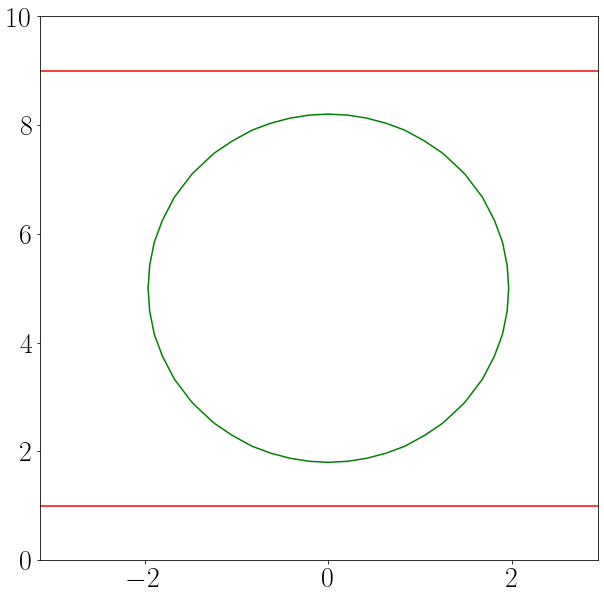

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
idx1 = 10
idx2 = 10

cont = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], quad_tabular_cbf.vf_table[:,idx1,:,idx2], levels=[0], colors='g')
ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], safe_values[:,idx1,:,idx2], levels=[0], colors='r')
ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], target_values[-1][:,idx1,:,idx2], levels=[0], colors='b')

In [ ]:
init_values = quad_tabular_cbf.vf_table
initial_time = 0.
final_time = -5.
times = jnp.linspace(initial_time, final_time, 101)
target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)

100%|##########|  5.0000/5.0 [05:07<00:00, 61.56s/sim_s]
